In [1]:
import sys
sys.path.append('..')  # To find camelid
import os
from os.path import join as pjoin
import csv

import pandas as pd
from pandas import DataFrame, Series
from rdkit import Chem, rdBase
from rdkit.Chem import AllChem, Draw, rdqueries, rdMolDescriptors
from rdkit.Chem.Draw import IPythonConsole
from sqlalchemy import create_engine
from sqlalchemy.sql import text

from camelid.env import CamelidEnv
from camelid.hypertext import cids_to_html

In [2]:
env = CamelidEnv(project='rdkit-testing')
conn = create_engine('postgresql://akokai@localhost/chmdata1')

2017-02-07 17:26:39,598 camelid.env INFO Project path: /opt/akokai/data/camelid/rdkit-testing


/opt/akokai/anaconda/envs/cmldev/lib/python3.5/site-packages/cairocffi/surfaces.py:651: UserWarning: implicit cast from 'char *' to a different pointer type: will be forbidden in the future (check that the types are as you expect; use an explicit ffi.cast() if they are correct)
  ffi.cast('char*', address), format, width, height, stride)
RDKit ERROR: [17:26:41] 
RDKit ERROR: 
RDKit ERROR: ****
RDKit ERROR: Pre-condition Violation
RDKit ERROR: getExplicitValence() called without call to calcExplicitValence()
RDKit ERROR: Violation occurred on line 174 in file /home/rdkit/miniconda/conda-bld/work/Code/GraphMol/Atom.cpp
RDKit ERROR: Failed Expression: d_explicitValence > -1
RDKit ERROR: ****
RDKit ERROR: 
RDKit ERROR: [17:26:41] Can't kekulize mol 
RDKit ERROR: 


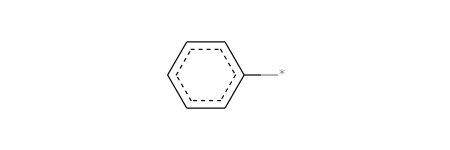

In [3]:
# Using an example from http://rdkit.blogspot.com/2016/07/tuning-substructure-queries-ii.html

smarts = 'c1ccccc1-[*]'
# mol = Chem.RWMol(Chem.MolFromSmarts(smarts))
qmol = Chem.AdjustQueryProperties(Chem.MolFromSmarts(smarts))
qmol

In [12]:
type(qmol)

rdkit.Chem.rdchem.Mol

In [4]:
Chem.MolToSmarts(qmol)

'[c&D2]1:,-[c&D2]:,-[c&D2]:,-[c&D2]:,-[c&D2]:,-[c&D3]:,-1-*'

In [5]:
# Not necessarily global constants:
TABLE = 'cpds'  # What DB table to query
FIELDS = ('cid', 'inchi', 'molecule')
MOLFIELD = 'molecule'

def smarts_query(qmol, table, fields, molfield, *args, **kwargs):
    where = "{0} @> '{1}'::qmol".format(molfield, str(qmol))
    content = [', '.join(fields), table, where]
    qtext = 'select {0} from {1} where {2};'.format(*content)
    return qtext

def query_results(conn, qtext):
    res = conn.execute(text(qtext))
    print(res.rowcount)
    return res.fetchall()

In [6]:
example = smarts_query(Chem.MolToSmarts(qmol), TABLE, FIELDS, MOLFIELD)
print(example)

select cid, inchi, molecule from cpds where molecule @> '[c&D2]1:,-[c&D2]:,-[c&D2]:,-[c&D2]:,-[c&D2]:,-[c&D3]:,-1-*'::qmol;


In [7]:
df = DataFrame(query_results(conn, example.strip(';') + ' limit 10;'), columns=['cid', 'inchi', 'mol'])

10


In [8]:
df

,cid,inchi,mol
0,66796542,"InChI=1S/C8H9FO2S/c9-6-7-12(10,11)8-4-2-1-3-5-...",O=S(=O)(CCF)c1ccccc1
1,66788907,"InChI=1S/C8H9IO2S/c9-7-12(10,11)6-8-4-2-1-3-5-...",O=S(=O)(CI)Cc1ccccc1
2,None,InChI=1S/C56H38N8O4.O.V/c1-5-13-33(14-6-1)65-3...,[O].[V+2].c1ccc(Oc2ccc3c4[n-]c([nH]c5[nH]c([nH...
3,71311253,InChI=1S/C56H38N8S4.Al.ClH/c1-5-17-33(18-6-1)6...,[Al+3].[Cl-].c1ccc(Sc2cccc3c4[n-]c([nH]c5[nH]c...
4,71311452,InChI=1S/C56H60N6O4/c1-5-35-33-61-27-23-39(35)...,CCC1CN2CC[C@@H]1CC2[C@H](Oc1nc(-c2ccccc2)nc(O[...
5,71376046,InChI=1S/C64H42/c1-5-21-45(22-6-1)63(46-23-7-2...,c1ccc(C2(c3ccccc3)c3ccccc3-c3ccc(-c4c5ccccc5c(...
6,None,InChI=1S/C100H66/c1-11-39-67(40-12-1)85-87(69-...,c1ccc(-c2c(-c3ccccc3)c(-c3ccccc3)c(-c3c4ccccc4...
7,67352486,"InChI=1S/C26H28O2Si3/c1-29(2,30(27,23-15-7-3-8...",C[Si](C)([Si](O)(c1ccccc1)c1ccccc1)[Si](O)(c1c...
8,66803235,InChI=1S/C13H17NO2S/c15-13(16)14-8-6-11(7-9-14...,O=C(O)N1CCC(CSc2ccccc2)CC1
9,66602794,InChI=1S/C18H26O6/c1-21-11-12-22-13-14-23-17(1...,COCCOCCOC(=O)CCCCC(=O)OCc1ccccc1


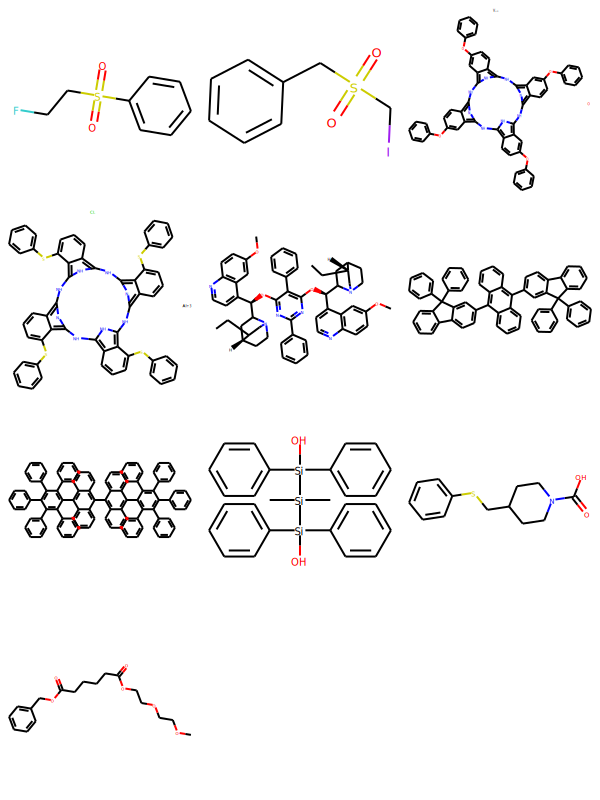

In [9]:
df['mol'] = df.inchi.apply(Chem.MolFromInchi)
Draw.MolsToGridImage(df.loc[:, 'mol'])

In [11]:
Draw.MolToFile(qmol, pjoin(env.results_path, 'qmol.png'), kekulize=False)

In [ ]:
def element_organic_qmol(element):
    pass